In [ ]:
# used for initializing the shapelets via KMeans
# NOTE: if you are just looking for a working solution of the learning shapelets algorithm you are advised to just use the implementation that is already provided by tslearn.
! pip install --user tslearn matplotlib

# Demo

The data set used is the FordA dataset of the UCR archive:
> Yanping Chen, Eamonn Keogh, Bing Hu, Nurjahan Begum, Anthony Bagnall, Abdullah Mueen and Gustavo Batista (2015). The UCR Time Series Classification Archive. URL www.cs.ucr.edu/~eamonn/time_series_data/.

### NOTE

To demonstrate the implementation, the shapelets to be learned are initialized
via K-Means as was done in the original paper. To do so, we use the K-Means implementation of the library TSLearn. If you are just looking for a working implementation of LearningShapelets, you are advised to just use the [TSLearn implementation](https://tslearn.readthedocs.io/en/latest/auto_examples/classification/plot_shapelet_distances.html). This repo just intends to provide an exemplary implementation using PyTorch.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# Path to root of this project, contains lots of modules
import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

In [2]:
import math
import random
import numpy
from matplotlib import pyplot
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

/home/jovyan/master-pytorch/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
#from learning_shapelets_Copy1 import LearningShapelets, MinEuclideanDistBlock
from src.learning_shapelets import LearningShapelets

### Load and Normalize Data

Helper functions to normalize the data:

In [4]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

Load and normalize training data:

In [5]:
dataset = "FaceFour"
# Load training data
X_train = numpy.load(open(os.path.join('data', f'{dataset}_train.npy'), 'rb'))
print(f"Shape X_train: {X_train.shape}")
# load trainng data labels
y_train = numpy.load(open(os.path.join('data', f'{dataset}_train_labels.npy'), 'rb'))
# normalize training data
X_train, scaler = normalize_data(X_train)

Shape X_train: (24, 1, 350)


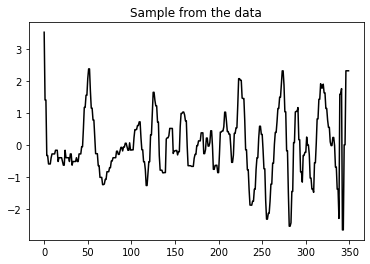

In [6]:
pyplot.title("Sample from the data")
pyplot.plot(X_train[0, 0], color='black')

### Initialize Model

In [7]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

In [8]:
def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters

Initialize parameters:

In [9]:
n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 2 shapelets of length 80
shapelets_size_and_len = {130: 2}
dist_measure = "euclidean"
lr = 1e-2
wd = 1e-3
epsilon = 1e-7

Initialize model:

In [10]:
learning_shapelets = LearningShapelets(len_ts=len_ts,
                                       shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=True,
                                       verbose=1,
                                       dist_measure=dist_measure)

Initialize shapelets via K-Means:

In [11]:
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    learning_shapelets.set_shapelet_weights_of_block(i, weights_block)

Initialize optimizer:

In [12]:
optimizer = optim.Adam(learning_shapelets.model.parameters(), lr=lr, weight_decay=wd, eps=epsilon)
learning_shapelets.set_optimizer(optimizer)

### Train Model

Train the model:

In [13]:
losses = learning_shapelets.fit(X_train, y_train, epochs=2000, batch_size=256, shuffle=False, drop_last=False)

Loss: 0.047213297337293625: 100%|██████████| 2000/2000 [00:11<00:00, 172.22it/s]


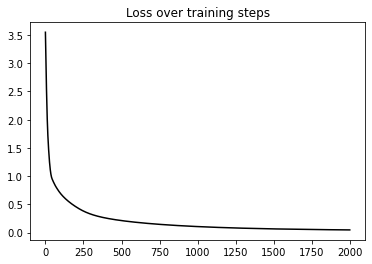

In [14]:
pyplot.plot(losses, color='black')
pyplot.title("Loss over training steps")
pyplot.show()

### Evaluate Model

In [15]:
def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")

Load test data:

In [16]:
# Load data set
X_test = numpy.load(open(os.path.join('data', f'{dataset}_test.npy'), 'rb'))
print(f"Shape X_train: {X_test.shape}")
y_test = numpy.load(open(os.path.join('data', f'{dataset}_test_labels.npy'), 'rb'))
# normalize data
X_train, scaler = normalize_data(X_train, scaler)

Shape X_train: (88, 1, 350)


In [17]:
eval_accuracy(learning_shapelets, X_test, y_test)

Accuracy: 0.9204545454545454


### Visualize Shapelets & Decision Boundaries

Parts of the code here are copied from the TSLearn demo: https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelet_distances.html#sphx-glr-auto-examples-classification-plot-shapelet-distances-py

In [18]:
def torch_dist_ts_shapelet(ts, shapelet, cuda=True):
    """
    Calculate euclidean distance of shapelet to a time series via PyTorch and returns the distance along with the position in the time series.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[2], 1)
    # calculate euclidean distance
    dists = torch.cdist(ts, shapelet, p=2)
    dists = torch.sum(dists, dim=0)
    # otherwise gradient will be None
    # hard min compared to soft-min from the paper
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, shapelet])
    return padded_shapelet

Get the shapelets from the classifier:

In [19]:
shapelets = learning_shapelets.get_shapelets()

Apply shapelet transform and extract the distances of the dataset to the shapelets:

In [20]:
shapelet_transform = learning_shapelets.transform(X_test)
dist_s1 = shapelet_transform[:, 0]
dist_s2 = shapelet_transform[:, 1]

Extract the weights and biases of the linear layer to plot the decision boundaries:

In [21]:
weights, biases = learning_shapelets.get_weights_linear_layer()

Plot shapelets on top of their 10 best matches as well as a plot of the decision boundaries:

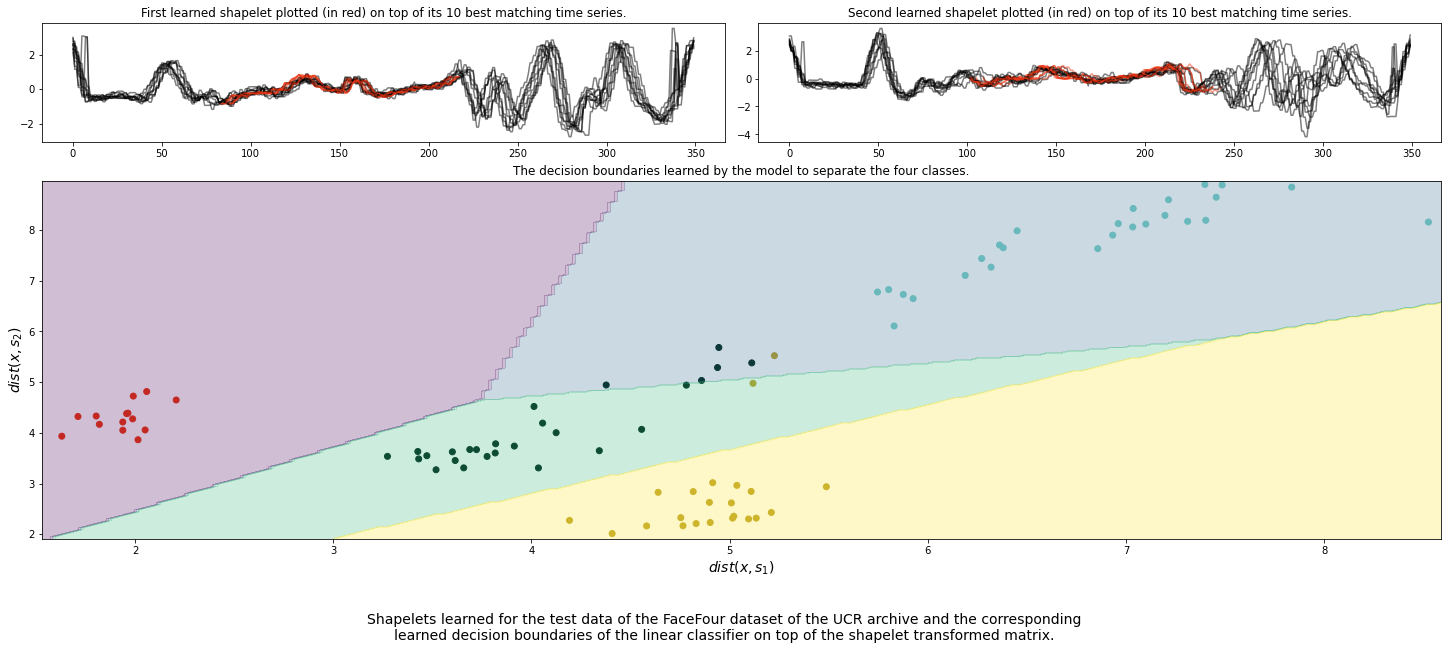

In [25]:
fig = pyplot.figure(constrained_layout=True, facecolor='white')
fig.set_size_inches(20, 8)
gs = fig.add_gridspec(4, 8)
fig_ax1 = fig.add_subplot(gs[0, :4])
fig_ax1.set_title("First learned shapelet plotted (in red) on top of its 10 best matching time series.")
for i in numpy.argsort(dist_s1)[:10]:
    fig_ax1.plot(X_test[i, 0], color='black', alpha=0.5)
    _, pos = torch_dist_ts_shapelet(X_test[i], shapelets[0])
    fig_ax1.plot(lead_pad_shapelet(shapelets[0, 0], pos), color='#F03613', alpha=0.5)

fig_ax2 = fig.add_subplot(gs[0, 4:])
fig_ax2.set_title("Second learned shapelet plotted (in red) on top of its 10 best matching time series.")
for i in numpy.argsort(dist_s2)[:10]:
    fig_ax2.plot(X_test[i, 0], color='black', alpha=0.5)
    _, pos = torch_dist_ts_shapelet(X_test[i], shapelets[1])
    fig_ax2.plot(lead_pad_shapelet(shapelets[1, 0], pos), color='#F03613', alpha=0.5)


fig_ax3 = fig.add_subplot(gs[1:, :])
fig_ax3.set_title("The decision boundaries learned by the model to separate the four classes.")
color = {0: '#F03613', 1: '#7BD4CC', 2: '#00281F', 3: '#BEA42E'}
fig_ax3.scatter(dist_s1, dist_s2, color=[color[l] for l in y_test])


viridis = cm.get_cmap('viridis', 4)
# Create a meshgrid of the decision boundaries
xmin = numpy.min(shapelet_transform[:, 0]) - 0.1
xmax = numpy.max(shapelet_transform[:, 0]) + 0.1
ymin = numpy.min(shapelet_transform[:, 1]) - 0.1
ymax = numpy.max(shapelet_transform[:, 1]) + 0.1
xx, yy = numpy.meshgrid(numpy.arange(xmin, xmax, (xmax - xmin)/200),
                        numpy.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
    Z.append(numpy.argmax([biases[i] + weights[i][0]*x + weights[i][1]*y
                           for i in range(4)]))
Z = numpy.array(Z).reshape(xx.shape)
fig_ax3.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)
fig_ax3.set_xlabel("$dist(x, s_1)$", fontsize=14)
fig_ax3.set_ylabel("$dist(x, s_2)$", fontsize=14)

caption = "Shapelets learned for the test data of the FaceFour dataset of the UCR archive and the corresponding\n" +\
          "learned decision boundaries of the linear classifier on top of the shapelet transformed matrix."
pyplot.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=14)
pyplot.savefig('learning_shapelets.png', facecolor=fig.get_facecolor())
pyplot.show()